# House Price Prediction - Advanced Regression Assignment

### Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The company is looking at prospective properties to buy to enter the market.

Build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.


### Business Goal 
Model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Understanding Data

In [1]:
#Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read data
house_df = pd.read_csv("train.csv")

In [3]:
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Observation
- 1460 rows, 81 columns
- Many variables have missing values.
- Target variable - SalePrice. No missing values for this variable
- Categorical variables, represented in int - MSSubClass,OverallQual,OverallCond
- Categorical variables - Year vars - YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
- Yes,No values - CentralAir
- GarageYrBlt - should be an int var. But is stored as float
- Id - variable represents unique ids. Not needed for analysis. Can be removed.
- From year variables - new features for age can be derived

In [6]:
#Numerical_variables
num_vars = list(house_df.select_dtypes(include = ['float64','int64']).columns)
#Categorical_variables
cat_vars = list(house_df.select_dtypes(include = ['object']).columns)
num_vars = list(set(num_vars)-set(['Id','MSSubClass','OverallQual','OverallCond','SalePrice','YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']))
#Numeric ordinal cat variables - 'OverallQual','OverallCond'
#String ordinal cat vars - values are as below
#       Ex	Excellent
#       Gd	Good
#       TA	Average/Typical
#       Fa	Fair
#       Po	Poor
#Year variables
yr_vars = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']
ord_cat_vars = ['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
cat_vars = list(set(cat_vars) - set(ord_cat_vars)) + ['MSSubClass']
print('Numeric Variables: ',num_vars)
print('Ordinal Categorical Variables: ',ord_cat_vars)
print('Categorical Variables: ',cat_vars)

Numeric Variables:  ['LotFrontage', 'BsmtFinSF2', 'WoodDeckSF', 'MoSold', 'Fireplaces', 'OpenPorchSF', 'MiscVal', 'PoolArea', 'MasVnrArea', 'HalfBath', 'GrLivArea', 'FullBath', 'BedroomAbvGr', '1stFlrSF', 'ScreenPorch', 'LotArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF', 'TotRmsAbvGrd', 'GarageArea', '2ndFlrSF', 'GarageCars', '3SsnPorch', 'EnclosedPorch', 'LowQualFinSF', 'KitchenAbvGr']
Ordinal Categorical Variables:  ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
Categorical Variables:  ['GarageType', 'BldgType', 'Functional', 'Street', 'MSZoning', 'CentralAir', 'PavedDrive', 'Fence', 'BsmtFinType1', 'MasVnrType', 'LotShape', 'Condition1', 'Foundation', 'SaleCondition', 'GarageFinish', 'BsmtFinType2', 'LotConfig', 'Exterior1st', 'BsmtExposure', 'SaleType', 'LandSlope', 'MiscFeature', 'HouseStyle', 'Utilities', 'Neighborhood', 'RoofMatl', '

In [7]:
len(num_vars+yr_vars+ord_cat_vars+cat_vars)

79

In [8]:
#Columns with missing values - in percentage
missing = round((house_df.isnull().sum()/house_df.shape[0])*100,2)
missing[missing>0].sort_values(ascending=False)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [9]:
#Understanding the column description from data dictionary
#Analyse the missing value has a meaning or not
#PoolQC
house_df['PoolQC'].value_counts()
#Null = NA - No Pool
house_df['MiscFeature'].value_counts()
#Null = NA - None
house_df['Alley'].value_counts()
#Null = NA - No alley access
house_df['Fence'].value_counts()
#Null = NA - No Fence
house_df['FireplaceQu'].value_counts()
#Null = NA - No Fireplace
house_df['BsmtQual'].value_counts()
#BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,
#Null = NA - No Basement
#GarageType, GarageFinish, GarageQual,GarageCond,
#Null = NA - No Garage

house_df['MasVnrType'].value_counts()
#Null => Can it be substituted with None?
#Electrical - No mapping for Null values. Can it be substituted using Others??

#Numerical Null features
#LotFrontage,MasVnrArea,GarageYrBlt
#Can these be substituted using mean or median?

house_df['GarageYrBlt'].value_counts()

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1927.0     1
1900.0     1
1906.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

In [10]:
house_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Data Pre-Processing
- Drop columns, which are not useful for analysis
- Converting the variables to correct datatype
- Converting the categorical variables to meaningful values
- Missing value treatment
- Derive new features

In [11]:
#Columns to drop
cols_to_drop = ['Id']
house_pre_process = house_df.drop(cols_to_drop, axis=1)
house_pre_process.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [12]:
#Categorical variables, represented in int - MSSubClass,OverallQual,OverallCond
#Convert to meaningful values
#MSSubClass: Identifies the type of dwelling involved in the sale.
#        20	1-STORY 1946 & NEWER ALL STYLES   => 1-STORY_1946_NEWER
#        30	1-STORY 1945 & OLDER              => 1-STORY_1945_OLDER
#        40	1-STORY W/FINISHED ATTIC ALL AGES => 1-STORY_W/FINISHED_ATTIC
#        45	1-1/2 STORY - UNFINISHED ALL AGES => 1.5-STORY_UNFINISHED
#        50	1-1/2 STORY FINISHED ALL AGES     => 1.5-STORY_FINISHED
#        60	2-STORY 1946 & NEWER              => 2-STORY_1946_NEWER
#        70	2-STORY 1945 & OLDER              => 2-STORY_1945_OLDER
#        75	2-1/2 STORY ALL AGES              => 2.5-STORY
#        80	SPLIT OR MULTI-LEVEL              => SPLIT_OR_MULTI_LEVEL
#        85	SPLIT FOYER                       => SPLIT_FOYER
#        90	DUPLEX - ALL STYLES AND AGES      => DUPLEX
#       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER => 1-STORY_PUD_1946_NEWER
#       150	1-1/2 STORY PUD - ALL AGES        => 1.5_STORY_PUD
#       160	2-STORY PUD - 1946 & NEWER        => 2-STORY_PID_1946_NEWER
#       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER =>PUD_MULTILEVEL_INCL_SPLIT/FOYER
#       190	2 FAMILY CONVERSION - ALL STYLES AND AGES => 2_FAMILY_CONV
house_pre_process['MSSubClass'] = house_pre_process['MSSubClass'].map({20:'1-STORY_1946_NEWER',30:'1-STORY_1945_OLDER',40:'1-STORY_W/FINISHED_ATTIC',45:'1.5-STORY_UNFINISHED',50:'1.5-STORY_FINISHED',60:'2-STORY_1946_NEWER',70:'2-STORY_1945_OLDER',75:'2.5-STORY',80:'SPLIT_OR_MULTI_LEVEL',85:'SPLIT_FOYER',90:'DUPLEX',120:'1-STORY_PUD_1946_NEWER',150:'1.5_STORY_PUD',160:'2-STORY_PID_1946_NEWER',180:'PUD_MULTILEVEL_INCL_SPLIT/FOYER',190:'2_FAMILY_CONV'})

house_pre_process['MSSubClass']

0       2-STORY_1946_NEWER
1       1-STORY_1946_NEWER
2       2-STORY_1946_NEWER
3       2-STORY_1945_OLDER
4       2-STORY_1946_NEWER
               ...        
1455    2-STORY_1946_NEWER
1456    1-STORY_1946_NEWER
1457    2-STORY_1945_OLDER
1458    1-STORY_1946_NEWER
1459    1-STORY_1946_NEWER
Name: MSSubClass, Length: 1460, dtype: object

In [13]:
set(missing[missing>0].index).intersection(cat_vars)

{'Alley',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'Fence',
 'GarageFinish',
 'GarageType',
 'MasVnrType',
 'MiscFeature'}

In [14]:
#Missing Value imputation
#Categorical variables
missing_cat_vars = set(missing[missing>0].index).intersection(ord_cat_vars+cat_vars)
print(missing_cat_vars)
#Variables to be imputed with NA
na_cat_vars = list(set(missing_cat_vars)-set(['MasVnrType','Electrical']))
#Other Categorical Variables
oth_cat_vars = ['MasVnrType','Electrical']
#Numerical variables
missing_num_vars = set(missing[missing>0].index).intersection(num_vars)
print(missing_num_vars)

{'BsmtFinType1', 'GarageType', 'MasVnrType', 'BsmtExposure', 'MiscFeature', 'GarageFinish', 'Alley', 'GarageCond', 'GarageQual', 'BsmtFinType2', 'Electrical', 'BsmtCond', 'FireplaceQu', 'BsmtQual', 'Fence', 'PoolQC'}
{'LotFrontage', 'MasVnrArea'}


In [15]:
#Categorical Variables - Impute with NA
for var in na_cat_vars:
    house_pre_process[var] = house_pre_process[var].fillna('NA')

#Categorical variables - Impute with None, Others
house_pre_process['MasVnrType'] = house_pre_process['MasVnrType'].fillna('None')
house_pre_process['Electrical'] = house_pre_process['Electrical'].fillna('Others')

In [16]:
#Numerical variables - Substitute using median

#Simple imputer - median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan,strategy ='median')

for var in missing_num_vars:
    house_pre_process[var] = imputer.fit_transform(house_pre_process[[var]].copy()).ravel()

In [17]:
#Check missing values again
missing_c = round((house_pre_process.isnull().sum()/house_pre_process.shape[0])*100,2)
missing_c[missing_c>0]

GarageYrBlt    5.55
dtype: float64

In [18]:
yr_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [19]:
#Handling Year variables
#Age of the house - from built year to sold year
house_pre_process['HouseAge']=house_pre_process['YrSold']-house_pre_process['YearBuilt']
#RemodelledAge - from remodelled year to sold year
house_pre_process['RemodelledAge']=house_pre_process['YrSold']-house_pre_process['YearRemodAdd']
#GarageAge - from garage built year to sold year
house_pre_process['GarageAge']=house_pre_process['YrSold']-house_pre_process['GarageYrBlt']
house_pre_process[yr_vars+['HouseAge','RemodelledAge','GarageAge']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,HouseAge,RemodelledAge,GarageAge
0,2003,2003,2003.0,2008,5,5,5.0
1,1976,1976,1976.0,2007,31,31,31.0
2,2001,2002,2001.0,2008,7,6,7.0
3,1915,1970,1998.0,2006,91,36,8.0
4,2000,2000,2000.0,2008,8,8,8.0
...,...,...,...,...,...,...,...
1455,1999,2000,1999.0,2007,8,7,8.0
1456,1978,1988,1978.0,2010,32,22,32.0
1457,1941,2006,1941.0,2010,69,4,69.0
1458,1950,1996,1950.0,2010,60,14,60.0


In [20]:
#Add new features into num_vars list
num_vars = num_vars+['HouseAge','RemodelledAge','GarageAge']

In [21]:
#Impute GarageAge with median
house_pre_process['GarageAge'] = imputer.fit_transform(house_pre_process[['GarageAge']].copy()).ravel().astype('int64')
#Remove year variables
house_pre_process = house_pre_process.drop(yr_vars,axis=1)

In [22]:
missing_d = round((house_pre_process.isnull().sum()/house_pre_process.shape[0])*100,2)
missing_d[missing_d>0]

Series([], dtype: float64)

In [23]:
#Converting Ordinal Categorical variables to proper values
str_ord_cat_vars = list(house_pre_process[ord_cat_vars].select_dtypes(include = ['object']).columns)
print(str_ord_cat_vars)
#       Ex	Excellent => 5
#       Gd	Good => 4
#       TA	Average/Typical => 3
#       Fa	Fair => 2
#       Po	Poor => 1
#       NA	None/No Garage/No Fireplace/No Basement => 0
for var in str_ord_cat_vars:
    house_pre_process[var] = house_pre_process[var].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

house_pre_process[ord_cat_vars].head()

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
0,7,5,4,3,4,3,5,4,0,3,3,0
1,6,8,3,3,4,3,5,3,3,3,3,0
2,7,5,4,3,4,3,5,4,3,3,3,0
3,7,5,3,3,3,4,4,4,4,3,3,0
4,8,5,4,3,4,3,5,4,3,3,3,0


### Exploratory Data Analysis

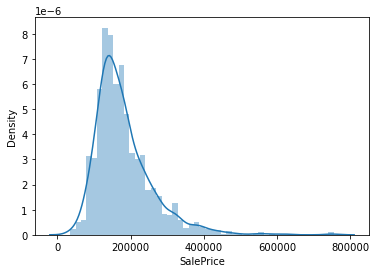

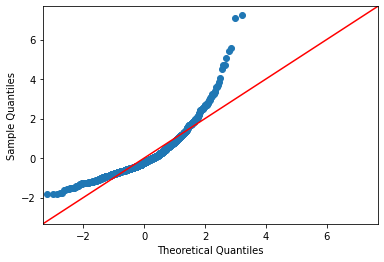

In [24]:
#Analyse the distribution of Target Variable
import statsmodels.api as sm
sns.distplot(house_pre_process['SalePrice'])
sm.qqplot(house_pre_process['SalePrice'], fit = True, line = "45")
plt.show()


Outlier and Skew in the target variable - SalePrice and it is not normally distributed. Log Transformation can solve.

In [25]:
len(num_vars)

32

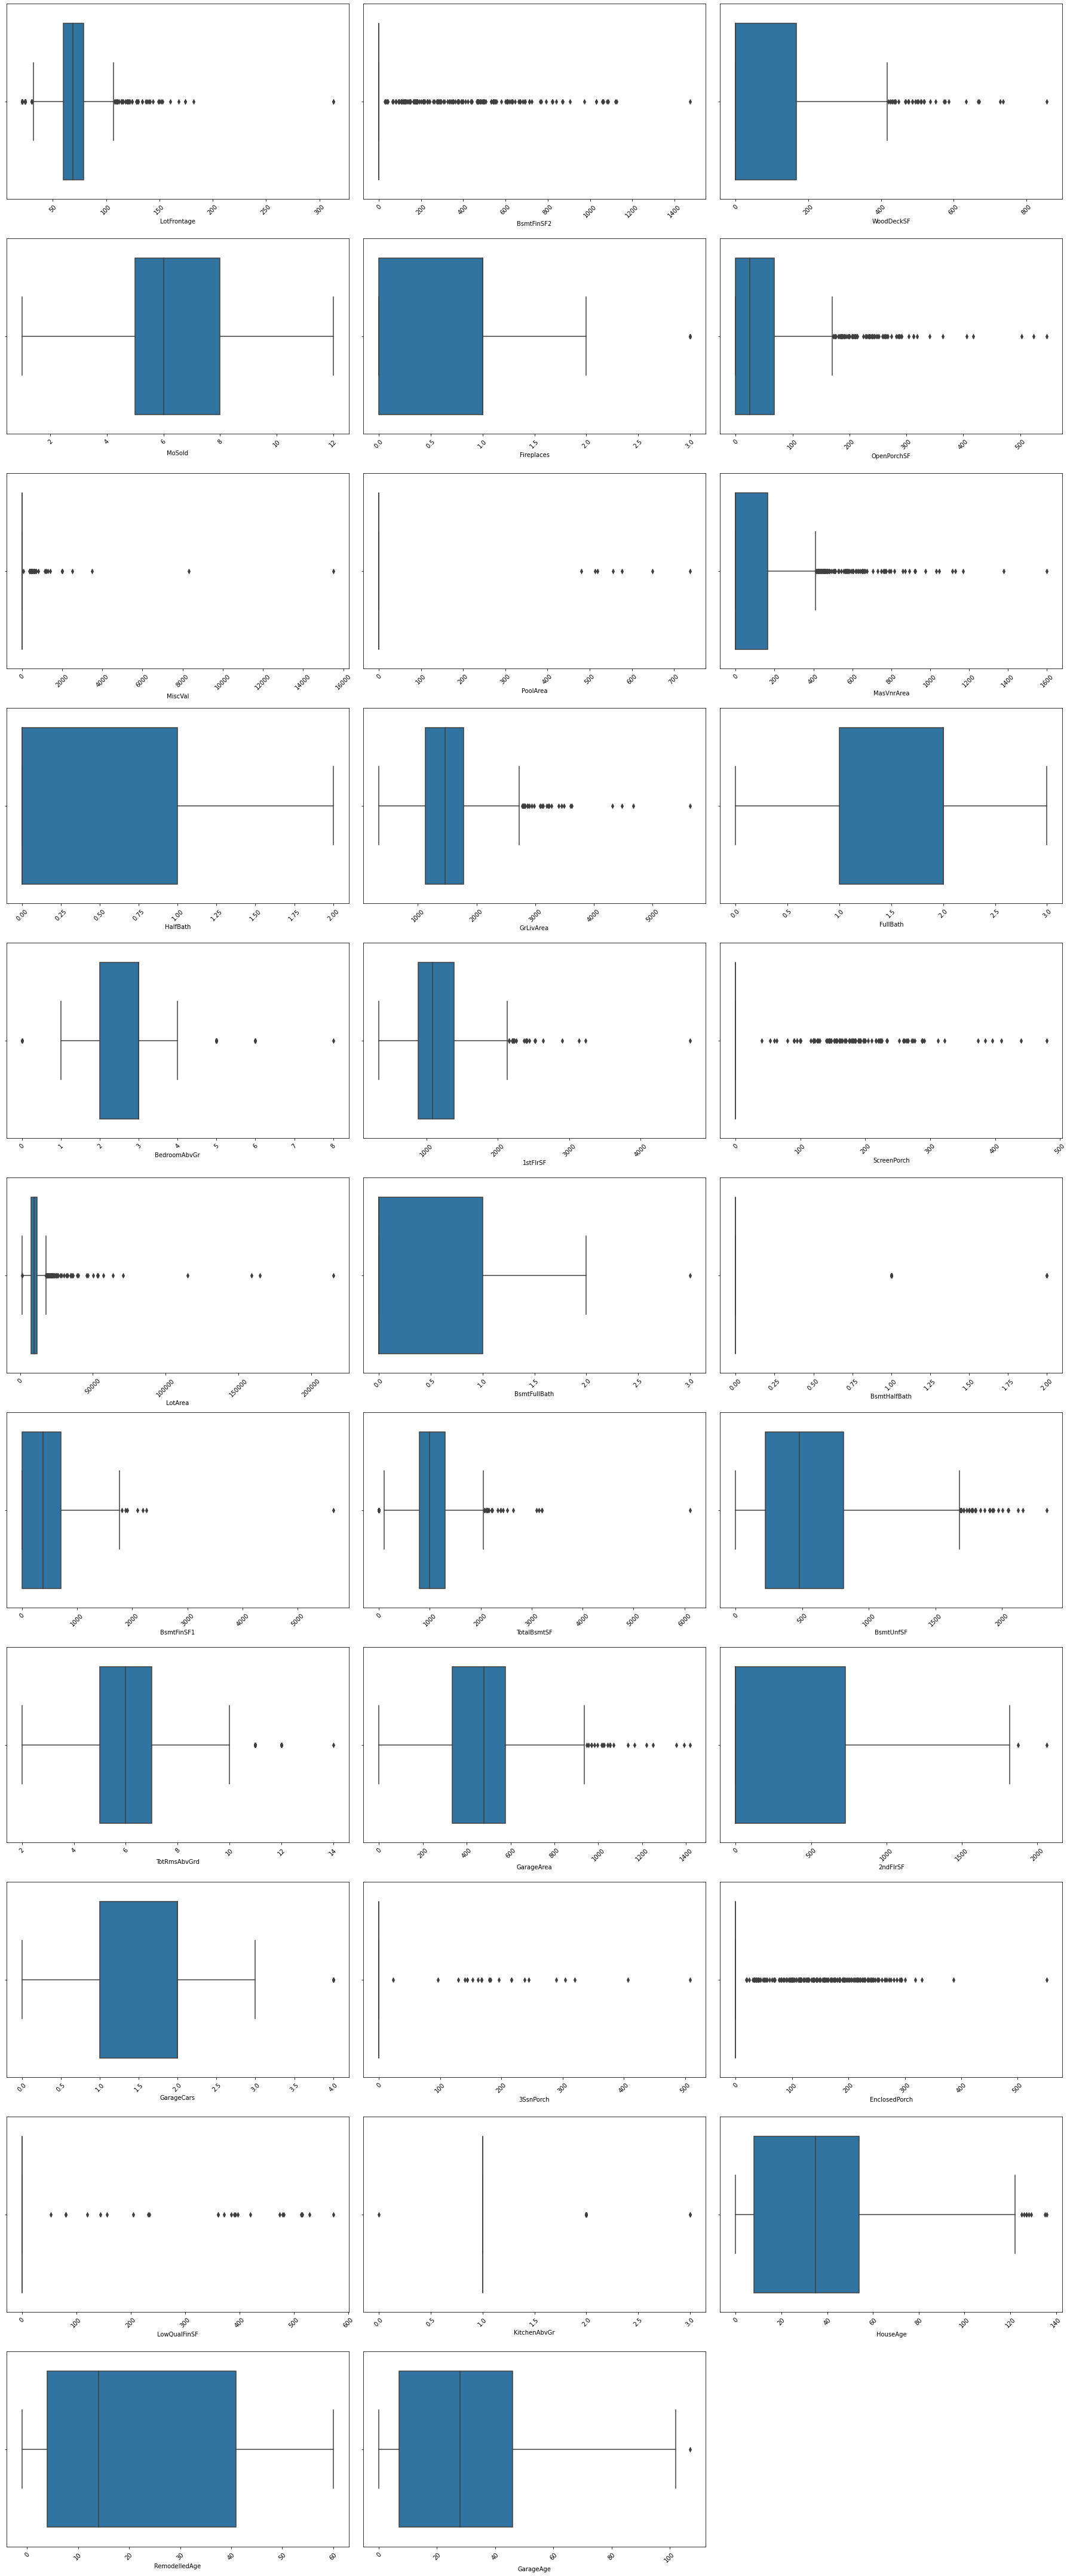

In [26]:
#Analyse other numeric variables

#Box plot for numeric variables
i=1
plt.figure(figsize=(25,60))
for var in num_vars:
    plt.subplot(11, 3, i)
    sns.boxplot(house_pre_process[var])
    plt.xticks(rotation=45)
    i=i+1

plt.tight_layout()
plt.show()

#Outliers in BsmtFinSF2, BsmtUnfSF,PoolArea, WoodDeckSF,TotalBsmtSF,3SsnPorch,BsmtFinSF1,ScreenPorch,LotFrontage,LotArea,MiscVal,LowQualFinSF,MasVnrArea,KitachenAbvGr,BedroomAbvGr,BsmtFullBath,Fireplaces,BsmtHalfBath,EnclosedPorch,OpenPorchSF,GarageArea,GarageCars,GrLivArea,1stFlrSF


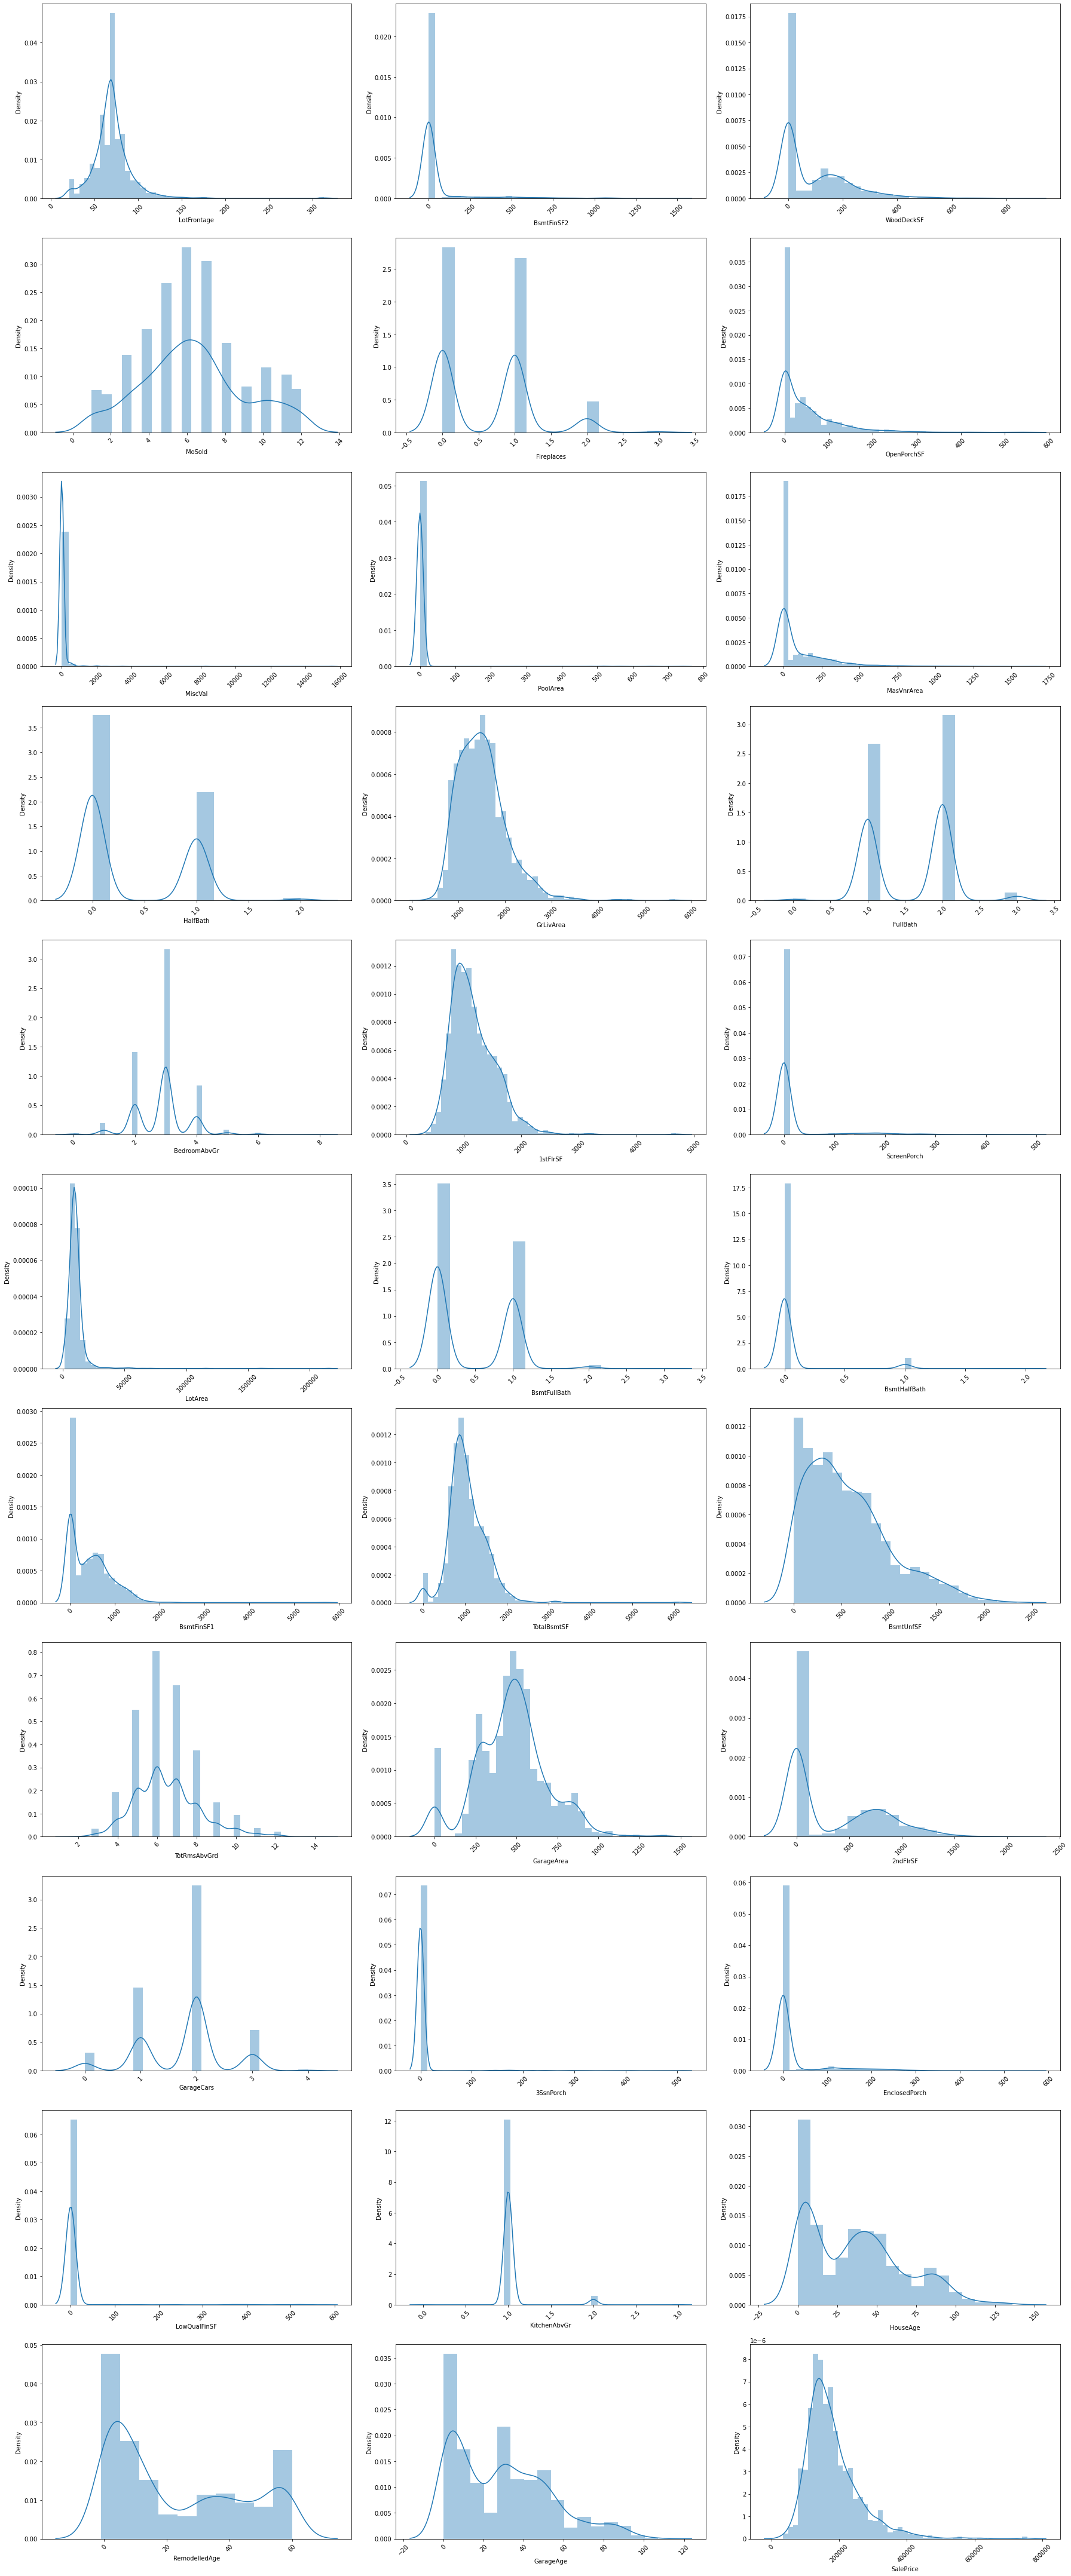

In [27]:
#Analyse the distribution of numerical variables

i=1
plt.figure(figsize=(25,60))
for var in num_vars+['SalePrice']:
    plt.subplot(11, 3, i)
    sns.distplot(house_pre_process[var])
    plt.xticks(rotation=45)
    i=i+1

plt.tight_layout()
plt.show()

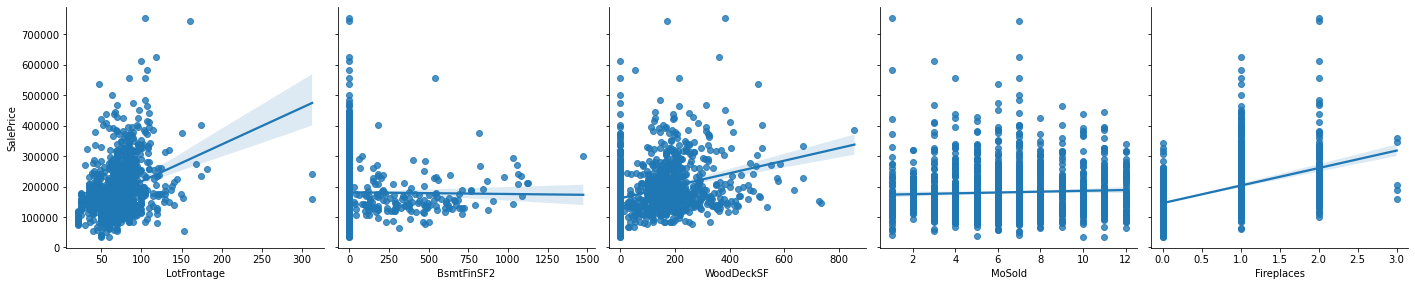

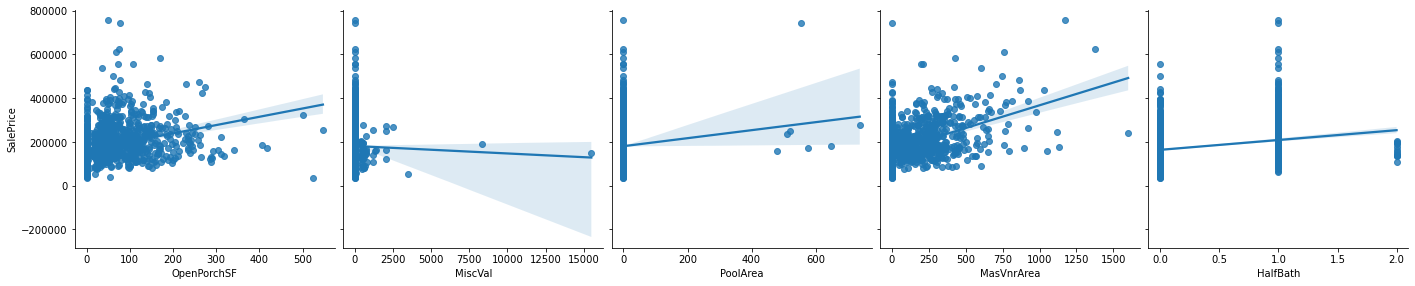

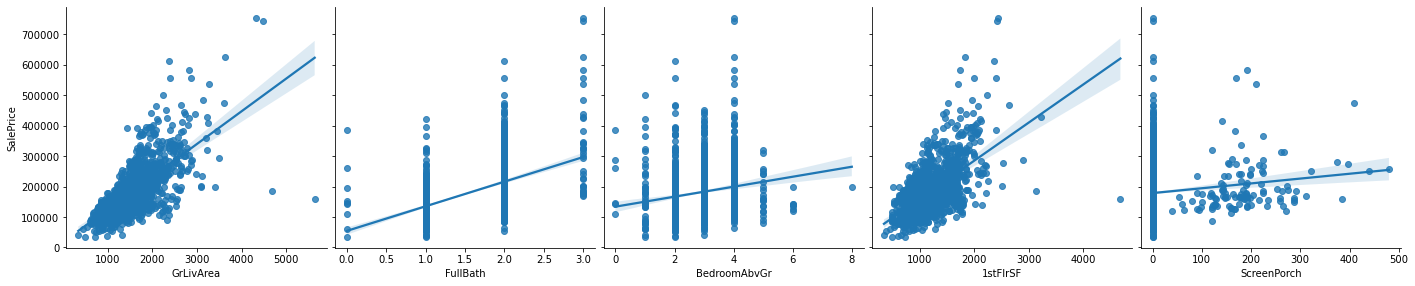

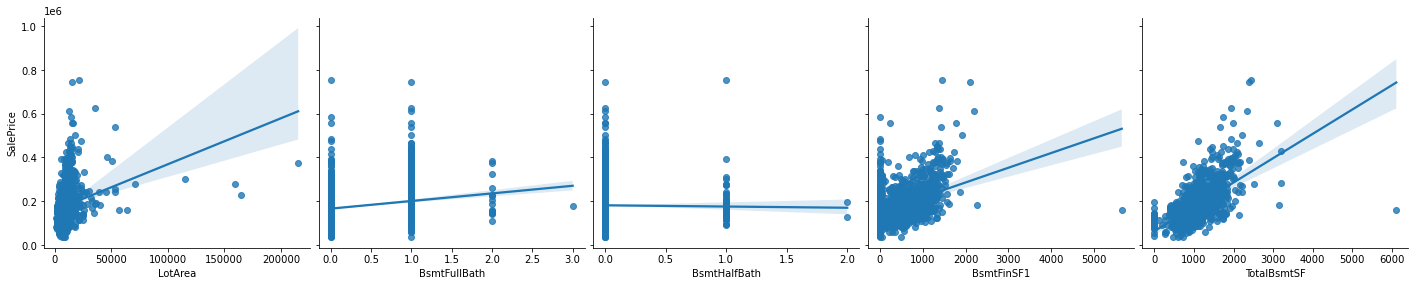

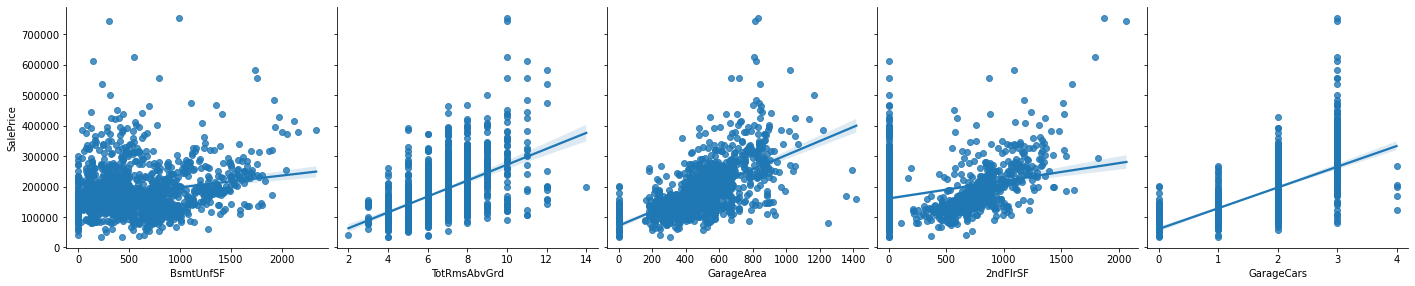

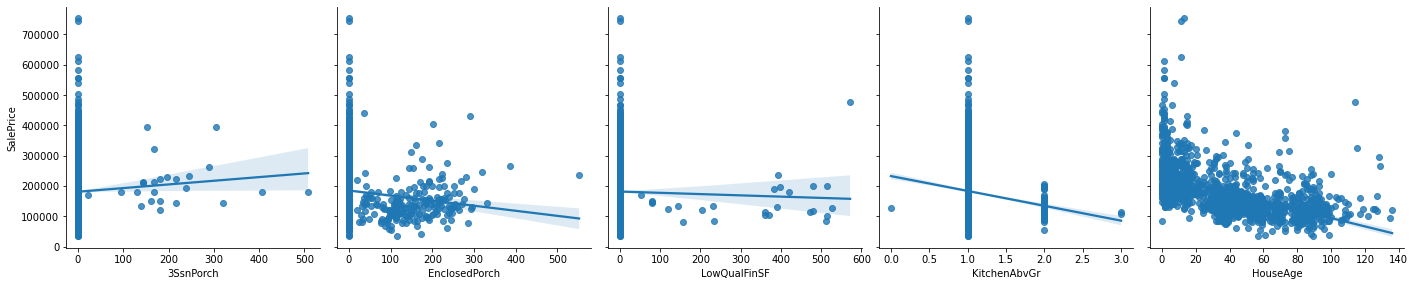

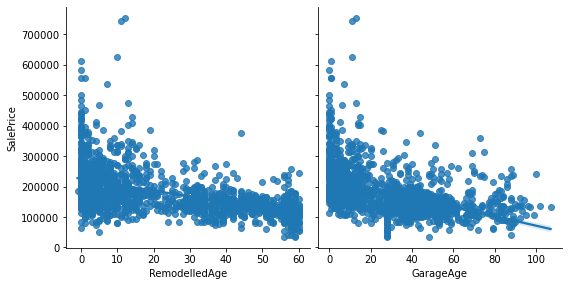

In [28]:
#Analyse the relation of numerical variables with target variable
i = 0
j = 0
x_var = []
m = len(num_vars)
for var in num_vars:
    i = i+1
    j = j+1
    x_var.append(var)
    if i/5 == 1:
        sns.pairplot(house_pre_process, x_vars=x_var, y_vars='SalePrice', size=4, aspect = 1, kind='reg', diag_kind=None)
        plt.show()
        i = 0
        x_var = []
    elif j == m:
        sns.pairplot(house_pre_process, x_vars=x_var, y_vars='SalePrice', size=4, aspect = 1, kind='reg', diag_kind=None)
        plt.show()


- Outliers and skew in most of the numerical variables. Robust scaler to be used
- GrLivArea, 1stFlrSF, BsmtFinSF1, TotalBsmtSF, GarageArea - has positive correlation with target variable
- HouseAge, RemodelledAge, GarageAge - has negative correlation with target variable

In [29]:
len(ord_cat_vars)

12

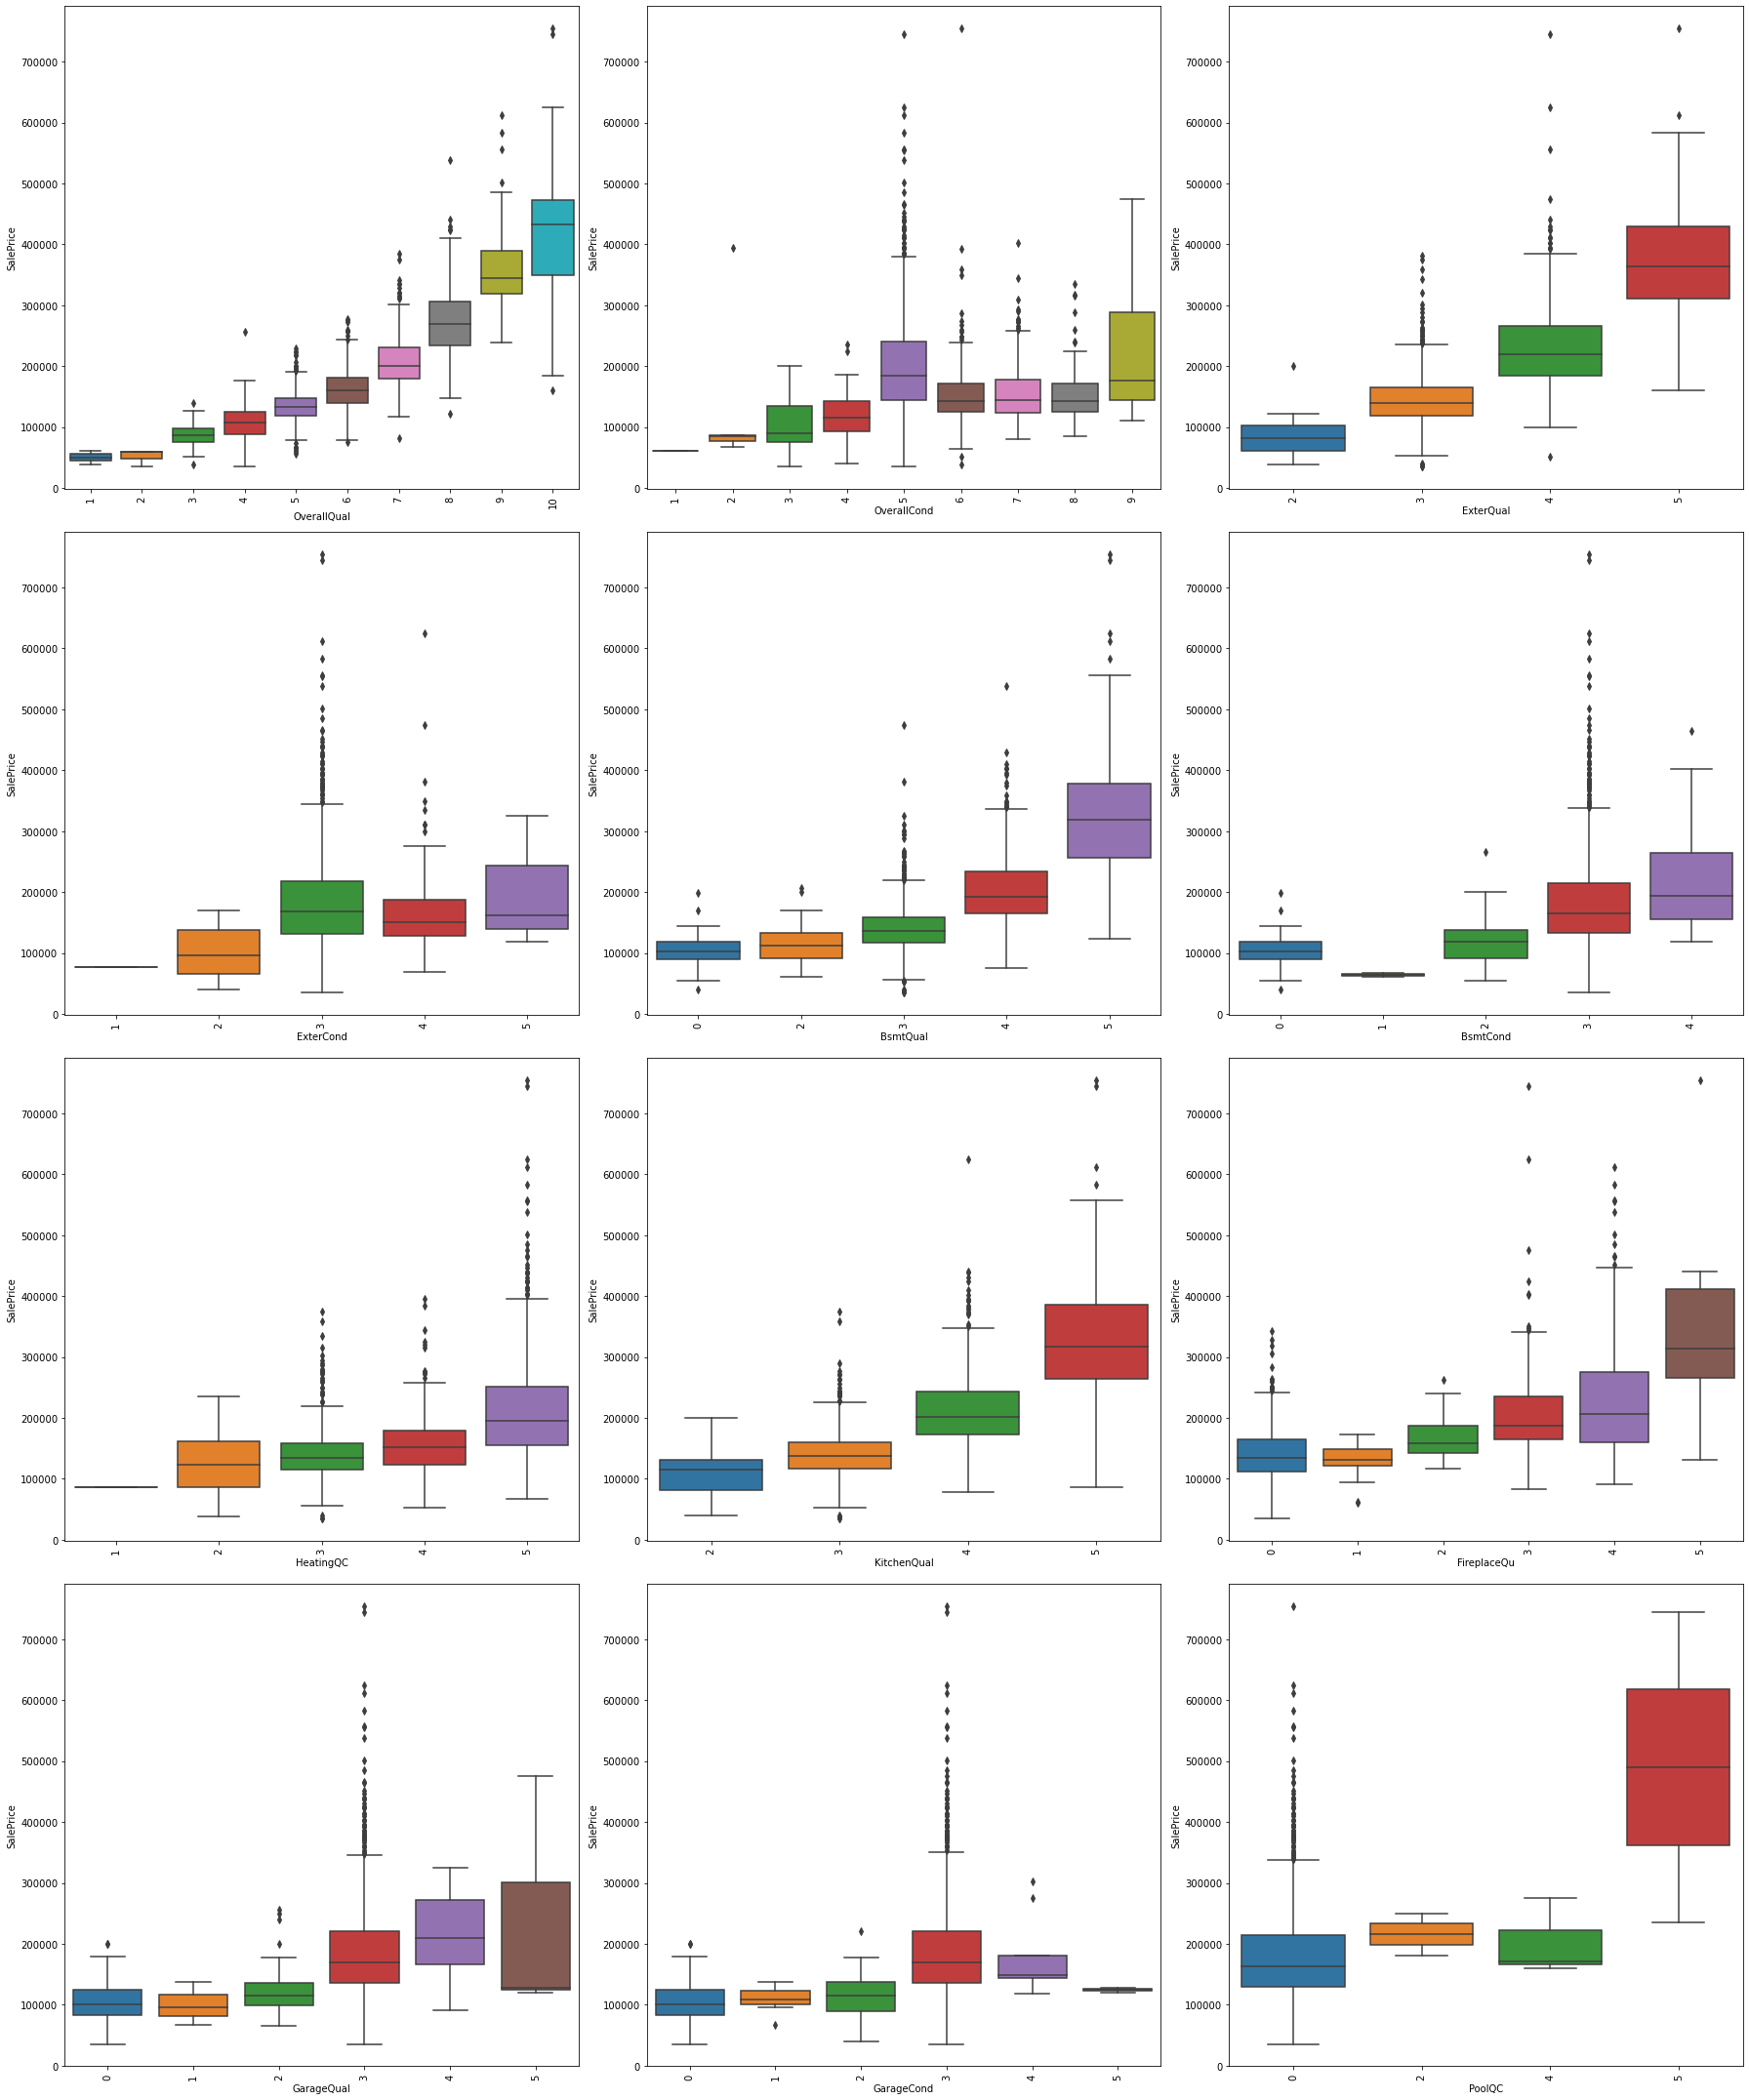

In [30]:
#Analysing ordinal categorical variables
i=1
plt.figure(figsize=(25,30))
for var in ord_cat_vars:
    plt.subplot(4, 3, i)
    sns.boxplot(x = var, y = 'SalePrice', data = house_pre_process)
    plt.xticks(rotation=90)
    i=i+1

plt.tight_layout()
plt.show()

Ordinal categorical features are showing increase in trend when the score increases. ie. SalePrice is high when quality is excellent and low when quality is poor.

In [31]:
len(cat_vars)

34

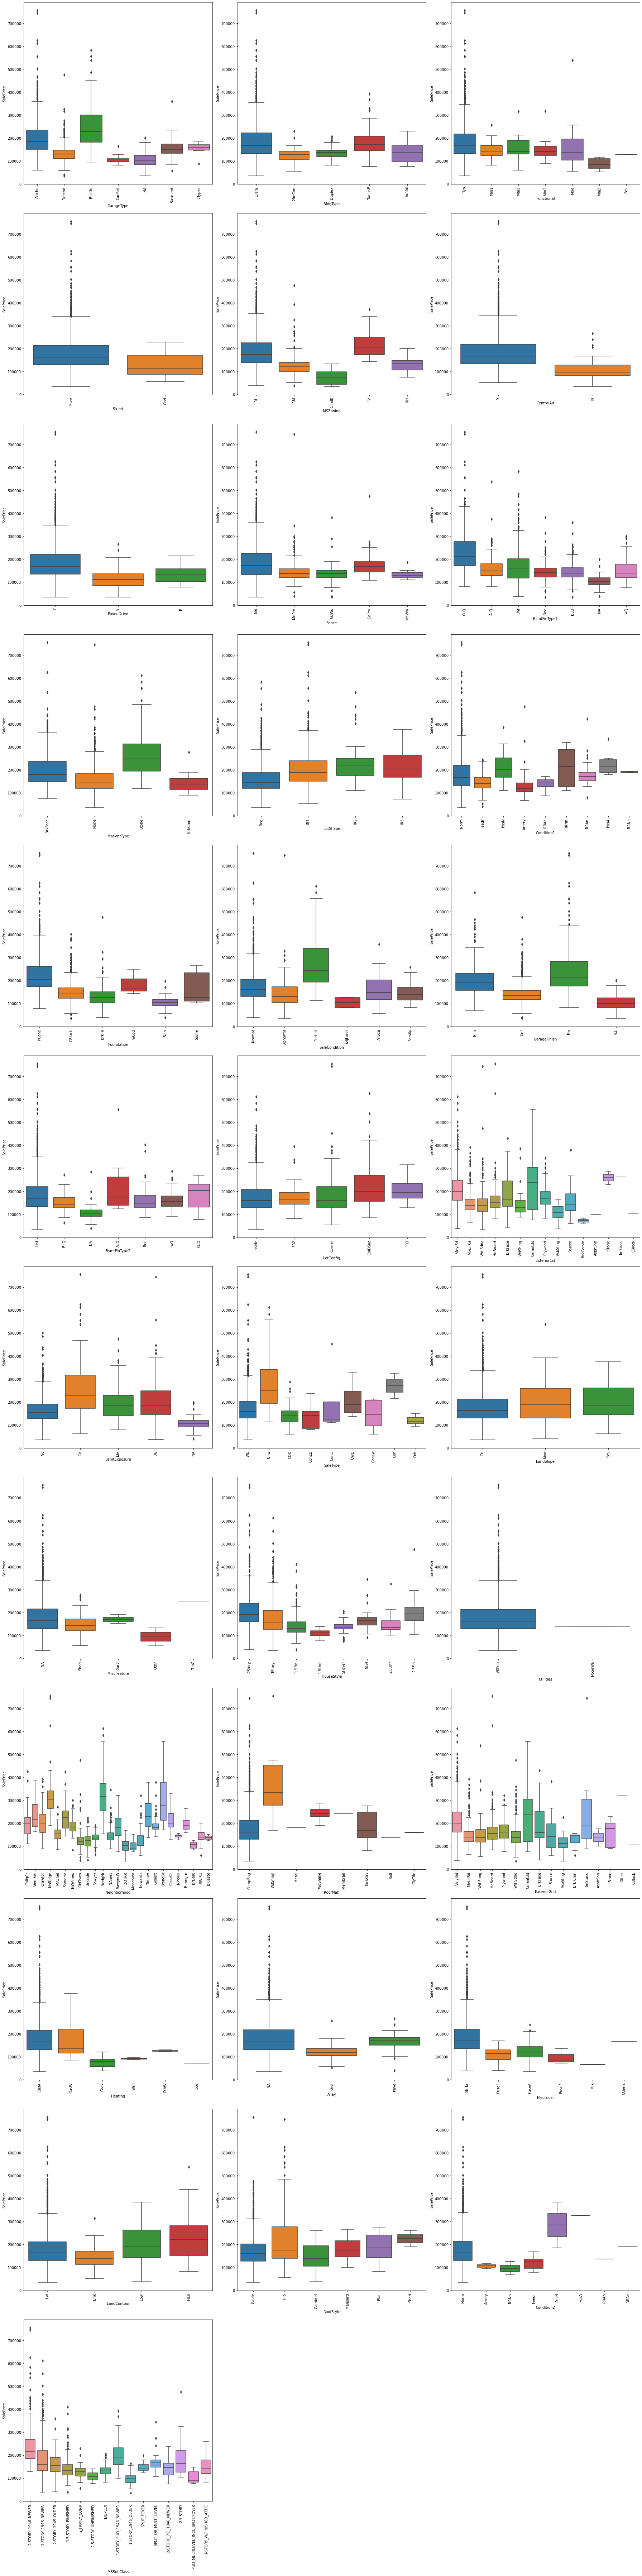

In [32]:
#Analysing categorical variables
i=1
plt.figure(figsize=(25,100))
for var in cat_vars:
    plt.subplot(12, 3, i)
    sns.boxplot(x = var, y = 'SalePrice', data = house_pre_process)
    plt.xticks(rotation=90)
    i=i+1

plt.tight_layout()
plt.show()

Outliers and skewness in categorical features - remove high skewed features

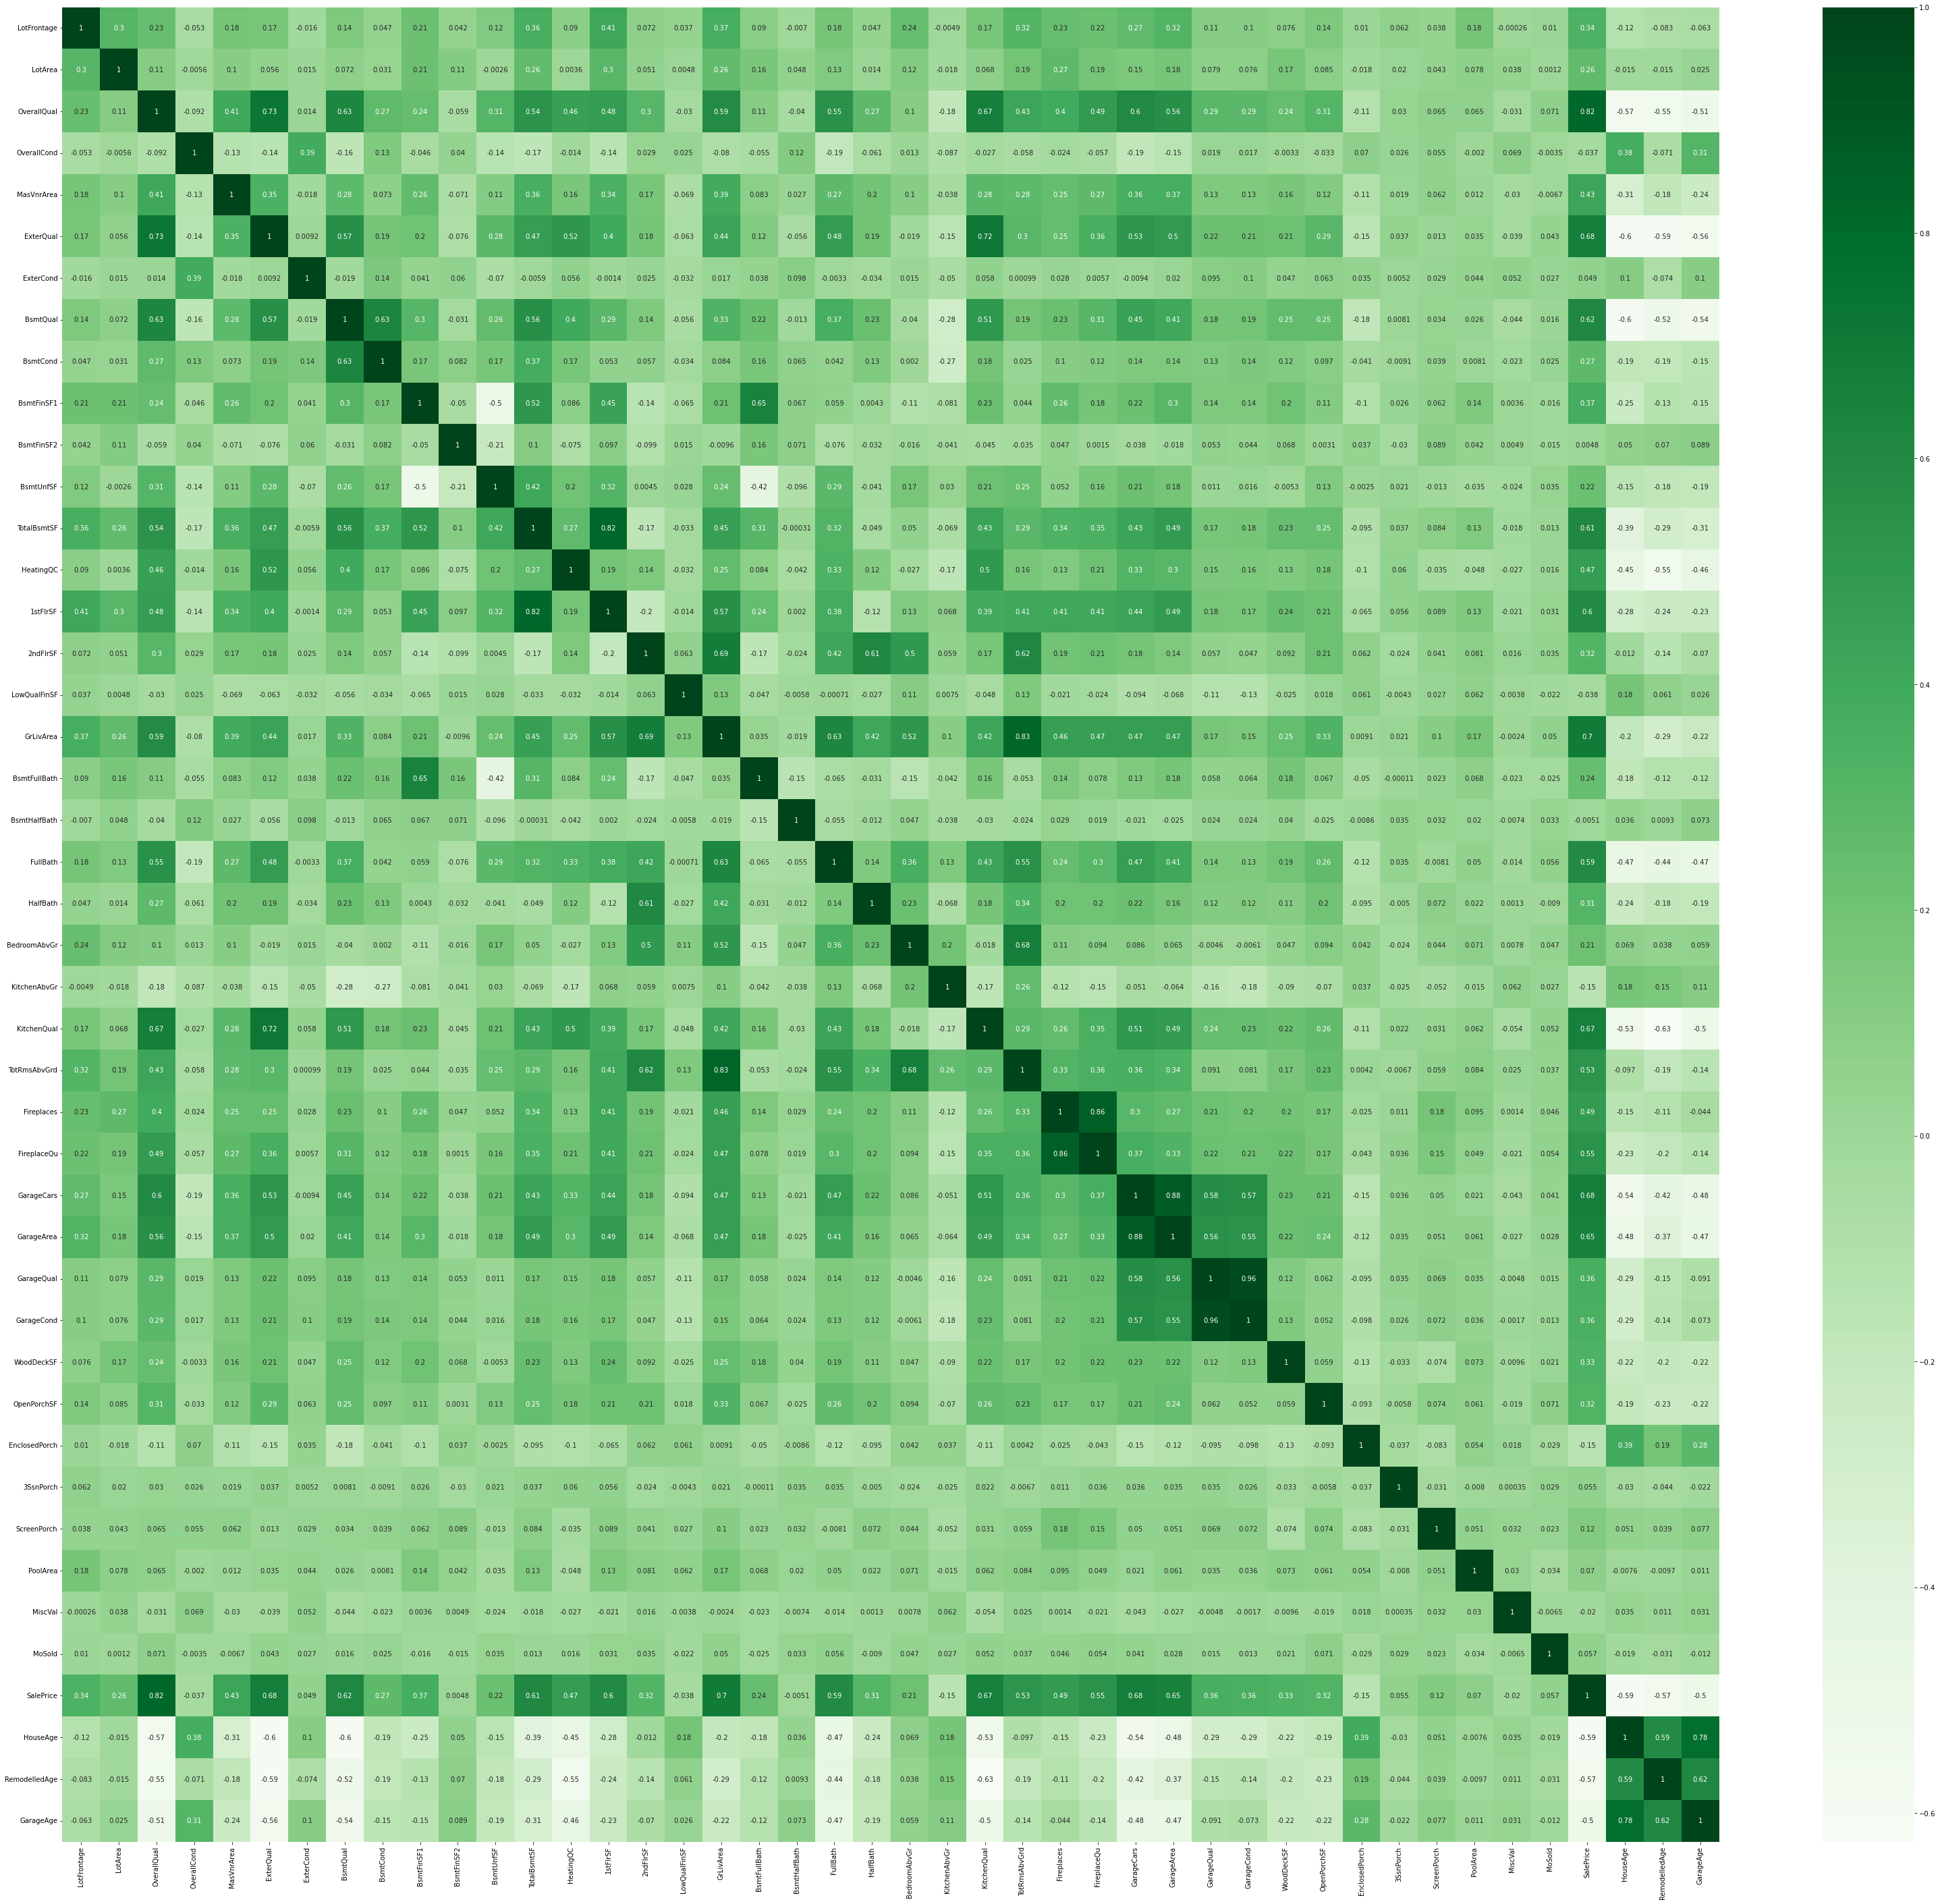

In [109]:
#Correlation of variables
#Plot heatmap
plt.figure(figsize = (55,50))
sns.heatmap(house_pre_process.corr(), annot = True, cmap="Greens")
plt.show()

- Features highly correlated with SalePrice
    - OverallQual, ExterQual, BsmtQual, TotalBsmtSF, 1stFlrSF, GivLivArea, FullBath, KitchenQual, GarageCars, GarageArea - positive correlation
    - HouseAge, RemodelledAge, GarageAge - negative correlation
- Features having correlation with each other
    - HouseAge, RemodelledAge, GarageAge
    - Age features and Quality/Condition features are negatively correlated
    - OverallQual, ExterQual, BsmtQual, KitchenQual
    - TotRmsAbvGrd, GrLivArea
    - Fireplaces, FireplaceQu
    - GarageCars, GarageArea
    - GarageQual, GarageCond

### Post EDA - Data Processing
- Identify skewed features
- Remove the highly skewed categorical features
- Log transformation on SalePrice to handle skew

In [34]:
#Skew Identification - Numerical Variables
skew_vars = house_pre_process[num_vars].apply(lambda x: x.skew())
skew_vars.sort_values(ascending=False)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.677616
LotFrontage       2.409147
OpenPorchSF       2.364342
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
TotRmsAbvGrd      0.676341
HalfBath          0.675897
GarageAge         0.668532
Fireplaces        0.649565
HouseAge          0.609030
BsmtFullBath      0.596067
RemodelledAge     0.502489
MoSold            0.212053
BedroomAbvGr      0.211790
GarageArea        0.179981
FullBath          0.036562
GarageCars       -0.342549
dtype: float64

In [35]:
#Skew identification - Categorical variables
skew_cat_vars = []
for var in cat_vars+ord_cat_vars:
    perc_skew = house_pre_process[var].value_counts().max()/house_pre_process[var].count()
    if perc_skew > 0.95:
        skew_cat_vars.append(var)
print(skew_cat_vars)

['Street', 'MiscFeature', 'Utilities', 'RoofMatl', 'Heating', 'Condition2', 'PoolQC']


In [36]:
#Drop the highly skewed categorical variables
house_pre_process.drop(skew_cat_vars,axis=1,inplace=True)

In [37]:
#Log Transformation on Target Feature - SalePrice
house_pre_process['SalePrice'] = np.log1p(house_pre_process['SalePrice'])
house_pre_process['SalePrice'].head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

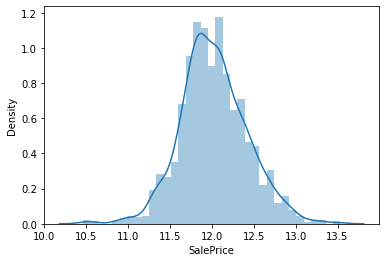

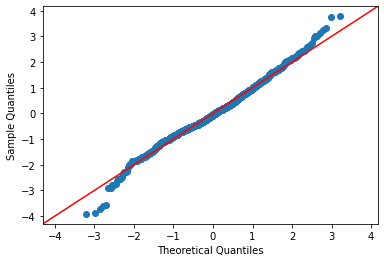

In [38]:
#Analyse the distribution post transformation
sns.distplot(house_pre_process['SalePrice'])
sm.qqplot(house_pre_process['SalePrice'], fit = True, line = "45")
plt.show()


### Final Dataset for model building

In [39]:
house_final_df = house_pre_process[:]
final_num_vars = list(house_final_df.select_dtypes(include = ['float64','int64']).columns)
final_num_vars.remove('SalePrice')
final_cat_vars = list(house_final_df.select_dtypes(include = ['object']).columns)

In [40]:
house_final_df.shape

(1460, 72)

In [41]:
house_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Alley          1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  OverallQual    1460 non-null   int64  
 14  OverallCond    1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrTy

In [42]:
house_final_df.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,HouseAge,RemodelledAge,GarageAge
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,69.863699,10516.828082,6.099315,5.575342,103.117123,3.39589,3.083562,3.489041,2.934932,443.639726,...,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,12.024057,36.547945,22.950000,29.233562
std,22.027677,9981.264932,1.382997,1.112799,180.731373,0.57428,0.351054,0.876478,0.552159,456.098091,...,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,0.399449,30.250152,20.640653,24.032554
min,21.000000,1300.000000,1.000000,1.000000,0.000000,2.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.460271,0.000000,-1.000000,0.000000
25%,60.000000,7553.500000,5.000000,5.000000,0.000000,3.00000,3.000000,3.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,11.775105,8.000000,4.000000,7.000000
50%,69.000000,9478.500000,6.000000,5.000000,0.000000,3.00000,3.000000,4.000000,3.000000,383.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,12.001512,35.000000,14.000000,28.000000
75%,79.000000,11601.500000,7.000000,6.000000,164.250000,4.00000,3.000000,4.000000,3.000000,712.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,12.273736,54.000000,41.000000,46.000000
max,313.000000,215245.000000,10.000000,9.000000,1600.000000,5.00000,5.000000,5.000000,4.000000,5644.000000,...,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,13.534474,136.000000,60.000000,107.000000


In [43]:
print(final_cat_vars)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']


In [44]:
#Dummy variable creation for categorical variables [Convert categories to 1,0]

#Yes,No values - CentralAir
house_final_df['CentralAir'] = house_final_df['CentralAir'].map({'Y':1,'N':0})

In [45]:
dummy_var = pd.get_dummies(house_final_df[list(set(final_cat_vars)-set('CentralAir'))], drop_first = True)
house_final_df = pd.concat([house_final_df, dummy_var], axis = 1)
house_final_df.drop(list(set(final_cat_vars)-set('CentralAir')), axis = 1, inplace = True)
print(house_final_df.shape)
house_final_df.columns

(1460, 216)


Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1',
       ...
       'Electrical_Others', 'Electrical_SBrkr', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'RoofStyle_Gable',
       'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard',
       'RoofStyle_Shed'],
      dtype='object', length=216)

## Splitting the data into Train-Test

In [46]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
df_train, df_test = train_test_split(house_final_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [47]:
print(df_train.shape)
print(df_test.shape)

(1021, 216)
(438, 216)


In [48]:
#Divide to X and y
y_train = df_train.pop('SalePrice')
X_train = df_train
y_test = df_test.pop('SalePrice')
X_test = df_test

In [49]:
y_train.head()

210     11.492733
318     12.468441
239     11.635152
986     11.669938
1416    11.715874
Name: SalePrice, dtype: float64

### Scaling the features

In [50]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[final_num_vars] = scaler.fit_transform(X_train[final_num_vars])
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,Electrical_Others,Electrical_SBrkr,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
210,-0.111111,-0.958190,-0.5,1.0,0.000000,0.0,0.0,-1.0,0.0,0.106742,...,0,0,0,0,1,1,0,0,0,0
318,1.166667,0.098377,0.5,0.0,1.620253,1.0,0.0,0.0,0.0,0.835674,...,0,1,0,1,0,1,0,0,0,0
239,-0.944444,-0.186670,0.0,-1.0,0.000000,0.0,0.0,-1.0,-1.0,-0.418539,...,0,0,0,0,1,1,0,0,0,0
986,-0.555556,-1.030497,0.0,3.0,0.000000,0.0,1.0,-1.0,-1.0,-0.550562,...,0,1,0,0,1,0,0,1,0,0
1416,-0.500000,0.452533,-1.0,1.0,0.000000,0.0,0.0,-1.0,0.0,-0.550562,...,0,1,0,0,1,1,0,0,0,0


In [51]:
#Scale test data
X_test[final_num_vars] = scaler.transform(X_test[final_num_vars])
X_test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,Electrical_Others,Electrical_SBrkr,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
1436,-0.500000,-0.122971,-1.0,1.0,0.000000,0.0,0.0,-1.0,0.0,0.314607,...,0,1,0,0,1,1,0,0,0,0
57,1.111111,0.527545,0.5,0.0,0.000000,1.0,0.0,0.0,0.0,-0.550562,...,0,1,0,0,1,1,0,0,0,0
780,-0.333333,-0.399656,0.5,0.0,0.240506,0.0,0.0,0.0,1.0,-0.550562,...,0,1,0,0,1,1,0,0,0,0
382,0.555556,-0.062715,0.5,0.0,0.000000,1.0,0.0,0.0,0.0,-0.550562,...,0,1,0,0,1,1,0,0,0,0
1170,0.388889,0.093458,0.0,1.0,0.000000,0.0,0.0,-1.0,0.0,0.182584,...,0,1,0,0,1,1,0,0,0,0


## Model Building

### Linear Regression

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lr = LinearRegression()
lr.fit(X_train, y_train)

rfe = RFE(lr, n_features_to_select=50)
rfe = rfe.fit(X_train, y_train)

In [53]:
sel_cols = X_train.columns[rfe.support_]
X_train_sel = X_train[sel_cols]

In [54]:
import statsmodels.api as sm  
def build_lr_model(X_train):
    #Add constant
    X_train_model = sm.add_constant(X_train)
    #Fit the model
    lr_model = sm.OLS(y_train,X_train_model).fit()
    return lr_model,X_train_model

In [55]:
lr_model1,X_train_model1 = build_lr_model(X_train_sel)
print(lr_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     171.8
Date:                Mon, 06 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:39:51   Log-Likelihood:                 644.25
No. Observations:                1021   AIC:                            -1190.
Df Residuals:                     972   BIC:                            -949.0
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [56]:
#Predict on train and test
y_train_pred_lr = lr_model1.predict(X_train_model1)
X_test_sel = X_test[X_train_sel.columns]
X_test_model1 = sm.add_constant(X_test_sel)
y_test_pred_lr = lr_model1.predict(X_test_model1)

In [57]:
#Model metrics
from sklearn.metrics import mean_squared_error, r2_score
def model_score(y,y_pred,nf):
    # The mean squared error
    mse=mean_squared_error(y, y_pred)
    # R-squared
    r2=r2_score(y, y_pred)
    #Adjusted R-squared
    adj_r2 = 1 - ((1-r2) * ((y.shape[0]-1)/(y.shape[0]-nf-1)))
    return mse,r2,adj_r2

In [58]:
lr_train_score = model_score(y_train,y_train_pred_lr,X_train_sel.shape[1])
lr_test_score = model_score(y_test,y_test_pred_lr,X_train_sel.shape[1])

In [59]:
print('LR Train Score:', lr_train_score)
print('LR Test Score:', lr_test_score)

LR Train Score: (0.016574828435643514, 0.8945549225184118, 0.8891196092461651)
LR Test Score: (0.022491536552293818, 0.8633048424857461, 0.845643969421889)


### Ridge Regression

In [60]:
#List of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [61]:
ridge = Ridge()

# cross validation
folds = 5
ridge_model = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model.fit(X_train, y_train) 


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [62]:
# Printing the best hyperparameter alpha
print(ridge_model.best_params_)

{'alpha': 20}


In [63]:
#Fitting the model for alpha = 10
alpha = 20
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-6.16223601e-03  7.21051988e-03  1.06074450e-01  3.76834603e-02
  1.10289624e-03  1.03625801e-02 -1.01067139e-02  2.64005154e-02
  1.35032573e-02  1.16005134e-03  3.94179106e-05  1.50840809e-03
  3.29358300e-03  1.99924632e-02  3.47490412e-02  4.47653999e-02
  1.85144256e-05  8.13126021e-02  4.51927703e-02  2.18714609e-03
  3.45621795e-02  3.13891907e-02  1.52485645e-02 -3.08075726e-02
  2.63620978e-02  2.40244624e-02  1.32575827e-02  4.70389632e-02
  4.73501731e-02  1.41502256e-02  1.95047448e-02 -3.48028943e-03
  1.60978617e-02 -1.77306407e-03  1.52305386e-04  2.55413828e-04
  1.93496866e-04 -4.12948128e-04 -4.22641495e-06 -8.77086679e-04
 -5.46014788e-02 -3.24631040e-02  3.95118687e-03  2.47597534e-02
 -7.86878441e-03 -6.16867012e-03 -1.36360124e-02 -3.20142899e-03
  1.42518966e-02 -1.10496806e-02  7.74511282e-03 -4.39367570e-02
 -1.55689512e-02 -1.62160112e-02  4.45425711e-03  7.73807875e-03
 -1.41128528e-02 -1.22635725e-02  2.86947259e-02  3.82336519e-02
  2.16954731e-02  4.93471

In [64]:
#Count the number of selected features
nf_ridge = len([i for i, e in enumerate(ridge.coef_) if e != 0])
print(nf_ridge)

212


In [65]:
#Predict on ridge model
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge =  ridge.predict(X_test)

In [66]:
y_train.shape[0]

1021

In [67]:
ridge_train_score = model_score(y_train,y_train_pred_ridge,nf_ridge)
ridge_test_score = model_score(y_test,y_test_pred_ridge,nf_ridge)

In [68]:
print('Ridge Train Score:', ridge_train_score)
print('Ridge Test Score:', ridge_test_score)

Ridge Train Score: (0.013690271454954344, 0.9129057812020973, 0.8900543277551228)
Ridge Test Score: (0.018483253010199343, 0.8876656925714872, 0.7818218117943996)


### Lasso Regression

In [69]:
#List of alphas to tune
params = {'alpha': [0.0005, 0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [70]:
lasso = Lasso()

# cross validation
folds = 5
lasso_model = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
lasso_model.fit(X_train, y_train) 


Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20,
                                   50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [71]:
# Printing the best hyperparameter alpha
print(lasso_model.best_params_)

{'alpha': 0.001}


In [113]:
#Fitting the model for alpha = 0.001 
alpha = 0.001
lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)
print(lasso.coef_)

[-5.71735732e-03  6.80137588e-03  1.21648254e-01  3.95147028e-02
  0.00000000e+00  1.81929522e-03 -0.00000000e+00  2.57809474e-02
  1.01732467e-02  0.00000000e+00 -1.66355948e-06  0.00000000e+00
  2.50458701e-03  1.66492463e-02  5.46798580e-03  0.00000000e+00
 -2.04204162e-05  1.32378597e-01  4.88656961e-02  0.00000000e+00
  2.32193485e-02  2.23662419e-02  1.18593566e-02 -7.78233453e-03
  2.42822130e-02  1.39296490e-02  2.56369531e-03  5.48296388e-02
  5.43779743e-02  5.09049449e-03  4.74291506e-03 -0.00000000e+00
  1.53142767e-02 -5.06462233e-04  1.54824589e-04  2.41491810e-04
  2.15381801e-04 -4.75297138e-04 -4.17852700e-06 -0.00000000e+00
 -7.19402131e-02 -3.08418310e-02 -0.00000000e+00  2.44827790e-02
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -4.36049167e-02
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.10071278e-02  1.65963930e-02
  0.00000000e+00  6.13086

In [114]:
#Count the number of selected features
nf_lasso = len([i for i, e in enumerate(lasso.coef_) if e != 0])
print(nf_lasso)

78


In [115]:
#Predict on Lasso model
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso =  lasso.predict(X_test)

In [116]:
X_train.shape

(1021, 215)

In [117]:
lasso_train_score = model_score(y_train,y_train_pred_lasso,nf_lasso)
lasso_test_score = model_score(y_test,y_test_pred_lasso,nf_lasso)

In [118]:
print('Lasso Train Score:', lasso_train_score)
print('Lasso Test Score:', lasso_test_score)

Lasso Train Score: (0.014791947258697756, 0.9058971843447383, 0.8981052314560861)
Lasso Test Score: (0.018635409564596157, 0.8867409418715188, 0.8621331242280047)


### Model Comparison

In [119]:
metric = ['MSE','R-Squared','Adj R-Squared']

model_metric = pd.DataFrame(metric, columns = ['Metric'])
model_metric['Linear Regression (Train)'] = lr_train_score
model_metric['Linear Regression (Test)'] = lr_test_score
model_metric['Ridge Regression (Train)'] = ridge_train_score
model_metric['Ridge Regression (Test)'] = ridge_test_score
model_metric['Lasso Regression (Train)'] = lasso_train_score
model_metric['Lasso Regression (Test)'] = lasso_test_score


model_metric

,Metric,Linear Regression (Train),Linear Regression (Test),Ridge Regression (Train),Ridge Regression (Test),Lasso Regression (Train),Lasso Regression (Test)
0,MSE,0.016575,0.022492,0.013690,0.018483,0.014792,0.018635
1,R-Squared,0.894555,0.863305,0.912906,0.887666,0.905897,0.886741
2,Adj R-Squared,0.889120,0.845644,0.890054,0.781822,0.898105,0.862133


In [120]:
#Features and Coefficients
model_coef = pd.DataFrame(ridge.feature_names_in_, columns = ['Feature'])
model_coef['Ridge'] = ridge.coef_
model_coef['Lasso'] = lasso.coef_
model_coef.head()

,Feature,Ridge,Lasso
0,LotFrontage,-0.006162,-0.005717
1,LotArea,0.007211,0.006801
2,OverallQual,0.106074,0.121648
3,OverallCond,0.037683,0.039515
4,MasVnrArea,0.001103,0.000000


In [140]:
#Top features - Ridge Regression
model_coef[['Feature','Ridge']].assign(s=abs(model_coef.Ridge)).sort_values(by='s',ascending=False).drop('s',axis=1).head(5)

,Feature,Ridge
2,OverallQual,0.106074
17,GrLivArea,0.081313
152,Neighborhood_Crawfor,0.071108
153,Neighborhood_Edwards,-0.065778
162,Neighborhood_NridgHt,0.063512


In [141]:
#Top features - Lasso Regression
model_coef[['Feature','Lasso']].assign(s=abs(model_coef.Lasso)).sort_values(by='s',ascending=False).drop('s',axis=1).head(5)

,Feature,Lasso
17,GrLivArea,0.132379
2,OverallQual,0.121648
167,Neighborhood_Somerst,0.099803
152,Neighborhood_Crawfor,0.097863
162,Neighborhood_NridgHt,0.083060


## Summary
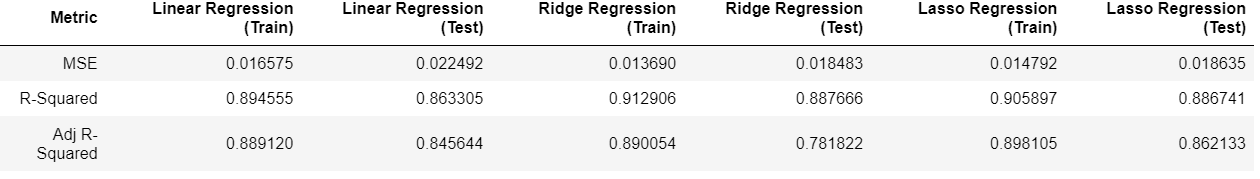
- Ridge Regression
    - Optimal Lambda -> 20
    - No of features selected -> 212
    - Differerence between train and test - rsquared is ~3%
    - Adjusted rsquared is less on test data
    - Top 5 Features
 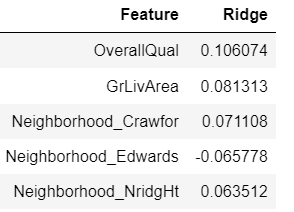
- Lasso Regression
    - Optimal Lambda -> 0.001
    - No of features selected -> 78
    - Differerence between train and test - rsquared is ~2%
    - Adjusted rsquared difference, between train and test is minimal and it is better
    - Top 5 features
 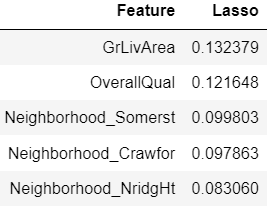
- Linear Regression model gives less performance compared to Ridge and Lasso
- Lasso selected very less features compared to Ridge and it has very good adjusted r-squared.
- Ridge and Lasso are performing better on both Train and Test, compared to Linear Regression.

### Subjective Questions

#### Question 1 - Doubling the value of alpha and try Ridge and Lasso

In [83]:
#Fitting the model for alpha = 3*2
alpha = 20*2
ridge_2 = Ridge(alpha=alpha)

ridge_2.fit(X_train, y_train)
print(ridge_2.coef_)

[-4.84836720e-03  7.32429514e-03  1.02528649e-01  3.80909178e-02
  3.10231234e-03  1.49917126e-02 -7.19872129e-03  2.87581237e-02
  1.09403455e-02  4.36862066e-03  3.69208539e-05  1.68595980e-03
  7.87948390e-03  1.99399689e-02  3.48155820e-02  3.84378347e-02
  2.52502299e-05  7.41142814e-02  4.01070440e-02  1.05853955e-03
  3.31736505e-02  2.96297695e-02  1.60052729e-02 -2.27589495e-02
  2.97442065e-02  2.61590006e-02  1.99815906e-02  4.16051762e-02
  4.37417916e-02  1.79976218e-02  1.42157141e-02  1.40882514e-05
  1.61641741e-02 -1.87197502e-03  1.34530661e-04  2.57801312e-04
  2.00826320e-04 -4.59506511e-04 -4.82296866e-06  2.17516621e-05
 -4.73817368e-02 -3.20434968e-02  1.12207867e-03  2.45146581e-02
 -6.25512934e-03 -2.40984470e-03 -1.06261531e-02 -6.46150053e-03
  6.80835515e-03 -1.01553181e-02  3.63086090e-03 -3.18588662e-02
 -1.00634531e-02 -9.11522943e-03  1.00081942e-03  3.91854208e-03
 -8.60489988e-03 -6.83510783e-03  2.28380779e-02  2.82679198e-02
  1.07142672e-02  3.79892

In [84]:
#Count the number of selected features
nf_ridge_2 = len([i for i, e in enumerate(ridge_2.coef_) if e != 0])
print(nf_ridge_2)

212


In [85]:
#Predict on ridge model
y_train_pred_ridge_2 = ridge_2.predict(X_train)
y_test_pred_ridge_2 =  ridge_2.predict(X_test)

In [86]:
ridge_2_train_score = model_score(y_train,y_train_pred_ridge_2,nf_ridge_2)
ridge_2_test_score = model_score(y_test,y_test_pred_ridge_2,nf_ridge_2)

In [87]:
print('Ridge Train Score:', ridge_2_train_score)
print('Ridge Test Score:', ridge_2_test_score)

Ridge Train Score: (0.01477145490766383, 0.9060275517600598, 0.8813714143505705)
Ridge Test Score: (0.01870439508759956, 0.8863216736320533, 0.7792114283431435)


In [88]:
#Lasso

In [123]:
#Fitting the model for alpha = 0.0001*2 
alpha = 0.001*2
lasso_2 = Lasso(alpha=alpha)

lasso_2.fit(X_train, y_train)
print(lasso_2.coef_)

[-1.69609291e-03  7.63952187e-03  1.33055670e-01  4.15259975e-02
  2.07753688e-03  3.27921521e-03  0.00000000e+00  3.03744646e-02
  0.00000000e+00  0.00000000e+00  1.25287874e-06  0.00000000e+00
  9.33910202e-03  2.16394050e-02  2.63763380e-03  0.00000000e+00
 -3.35206053e-05  1.34100280e-01  4.65864962e-02  0.00000000e+00
  1.38684189e-02  1.05054164e-02  1.02104708e-02 -0.00000000e+00
  2.88191516e-02  1.04882847e-02  8.07215309e-03  5.30659264e-02
  5.89194508e-02  5.64631449e-03  1.31651922e-03  0.00000000e+00
  1.45280398e-02 -0.00000000e+00  1.27623413e-04  2.46487788e-04
  2.23414699e-04 -5.89114116e-04 -3.33981101e-06 -0.00000000e+00
 -7.32336538e-02 -2.68713337e-02 -0.00000000e+00  2.51475329e-02
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.28054461e-02
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.08272

In [124]:
#Count the number of selected features
nf_lasso_2 = len([i for i, e in enumerate(lasso_2.coef_) if e != 0])
print(nf_lasso_2)

56


In [125]:
#Predict on Lasso model
y_train_pred_lasso_2 = lasso_2.predict(X_train)
y_test_pred_lasso_2 =  lasso_2.predict(X_test)

In [126]:
lasso_2_train_score = model_score(y_train,y_train_pred_lasso_2,nf_lasso_2)
lasso_2_test_score = model_score(y_test,y_test_pred_lasso_2,nf_lasso_2)

In [127]:
print('Lasso Train Score:', lasso_2_train_score)
print('Lasso Test Score:', lasso_2_test_score)

Lasso Train Score: (0.016857916796711565, 0.8927539823588887, 0.8865239232428075)
Lasso Test Score: (0.019784913738743182, 0.8797546848951231, 0.8620808328062173)


In [94]:
#Compare Models

In [128]:
metric = ['MSE','R-Squared','Adj R-Squared']

model_metric_2 = pd.DataFrame(metric, columns = ['Metric'])
model_metric_2['Ridge Regression (Train)'] = ridge_train_score
model_metric_2['Ridge Regression (Test)'] = ridge_test_score
model_metric_2['Ridge Regression2 (Train)'] = ridge_2_train_score
model_metric_2['Ridge Regression2 (Test)'] = ridge_2_test_score
model_metric_2['Lasso Regression (Train)'] = lasso_train_score
model_metric_2['Lasso Regression (Test)'] = lasso_test_score
model_metric_2['Lasso Regression2 (Train)'] = lasso_2_train_score
model_metric_2['Lasso Regression2 (Test)'] = lasso_2_test_score


model_metric_2

,Metric,Ridge Regression (Train),Ridge Regression (Test),Ridge Regression2 (Train),Ridge Regression2 (Test),Lasso Regression (Train),Lasso Regression (Test),Lasso Regression2 (Train),Lasso Regression2 (Test)
0,MSE,0.013690,0.018483,0.014771,0.018704,0.014792,0.018635,0.016858,0.019785
1,R-Squared,0.912906,0.887666,0.906028,0.886322,0.905897,0.886741,0.892754,0.879755
2,Adj R-Squared,0.890054,0.781822,0.881371,0.779211,0.898105,0.862133,0.886524,0.862081


In [129]:
#Top 5 features new model - Lasso Regression
#Features and Coefficients
model_coef_2 = pd.DataFrame(lasso_2.feature_names_in_, columns = ['Feature'])
model_coef_2['Lasso'] = lasso_2.coef_
model_coef_2.head()
model_coef_2.assign(s=abs(model_coef_2.Lasso)).sort_values(by='s',ascending=False).drop('s',axis=1).head(5)

,Feature,Lasso
17,GrLivArea,0.134100
2,OverallQual,0.133056
40,HouseAge,-0.073234
167,Neighborhood_Somerst,0.064620
28,GarageCars,0.058919


In [142]:
model_coef_2['Ridge'] = ridge_2.coef_
model_coef_2.head()
model_coef_2[['Feature','Ridge']].assign(s=abs(model_coef_2.Ridge)).sort_values(by='s',ascending=False).drop('s',axis=1).head(5)

,Feature,Ridge
2,OverallQual,0.102529
17,GrLivArea,0.074114
153,Neighborhood_Edwards,-0.052400
152,Neighborhood_Crawfor,0.051126
40,HouseAge,-0.047382


- By doubling the lambda values for Ridge and Lasso regression, the r-squared and adjusted r-squared have dropped and MSE has slight increase. 
- Among the top 5 features, the top 2 features remained same in both the cases, but with an increase in coefficient value for the doubled alpha. The next 3 features got modified with decrease in coefficients.
- The number of features remained same for Ridge, but has dropped in case of Lasso.

#### Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [147]:
#Remove the top 5 predictor variables from X_train and X_test
#Build Lasso model using alpha=0.0001
lasso_imp_vars = model_coef[['Feature','Lasso']].assign(s=abs(model_coef.Lasso)).sort_values(by='s',ascending=False).drop('s',axis=1).head(5)['Feature']
X_train_upd = X_train.drop(lasso_imp_vars,axis=1)
X_test_upd = X_test.drop(lasso_imp_vars,axis=1)
print(X_train.shape)
print(X_test.shape)
print(X_train_upd.shape)
print(X_test_upd.shape)

(1021, 215)
(438, 215)
(1021, 210)
(438, 210)


In [148]:
#Fitting the model for alpha = 0.001
alpha = 0.001
lasso_3 = Lasso(alpha=alpha)

lasso_3.fit(X_train_upd, y_train)
print(lasso_3.coef_)

[-6.68553652e-03  6.49448487e-03  4.61839713e-02  6.09013132e-03
  3.38012868e-02 -4.40969251e-03  4.25812227e-02  7.03987468e-03
 -0.00000000e+00  1.09220522e-05  2.46262742e-05  5.97316540e-03
  1.36055466e-02  1.29589823e-01  1.55006944e-01  1.73707915e-04
  3.85886671e-02 -0.00000000e+00  3.52541971e-02  2.07003640e-02
  5.14289322e-03 -3.52017777e-02  3.93040103e-02  2.74914906e-02
  7.63668408e-03  8.12529719e-02  5.25920276e-02  1.54142922e-02
  1.97838413e-03  0.00000000e+00  1.08486777e-02 -0.00000000e+00
  1.91546278e-04  2.51509735e-04  2.08944194e-04 -4.58000998e-04
 -3.99521897e-06  3.72278933e-04 -8.57541298e-02 -3.17425696e-02
  0.00000000e+00  2.95719446e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -2.66267037e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  4.06969771e-02  9.20545935e-02  0.00000000e+00  5.58044107e-02
 -0.00000000e+00  0.00000

In [149]:
#Count the number of selected features
nf_lasso_3 = len([i for i, e in enumerate(lasso_3.coef_) if e != 0])
print(nf_lasso_3)

84


In [150]:
#Predict on Lasso model
y_train_pred_lasso_3 = lasso_3.predict(X_train_upd)
y_test_pred_lasso_3 =  lasso_3.predict(X_test_upd)

In [151]:
lasso_3_train_score = model_score(y_train,y_train_pred_lasso_3,nf_lasso_3)
lasso_3_test_score = model_score(y_test,y_test_pred_lasso_3,nf_lasso_3)

In [152]:
print('Lasso Train Score:', lasso_3_train_score)
print('Lasso Test Score:', lasso_3_test_score)

Lasso Train Score: (0.01667768142331106, 0.8939005965146207, 0.8843788551761893)
Lasso Test Score: (0.020698665837208776, 0.8742012409701906, 0.8442661255070065)


In [153]:
#Compare Models

In [154]:
metric = ['MSE','R-Squared','Adj R-Squared']

model_metric_3 = pd.DataFrame(metric, columns = ['Metric'])
model_metric_3['Lasso Regression (Train)'] = lasso_train_score
model_metric_3['Lasso Regression (Test)'] = lasso_test_score
model_metric_3['Lasso Regression3 (Train)'] = lasso_3_train_score
model_metric_3['Lasso Regression3 (Test)'] = lasso_3_test_score


model_metric_3

,Metric,Lasso Regression (Train),Lasso Regression (Test),Lasso Regression3 (Train),Lasso Regression3 (Test)
0,MSE,0.014792,0.018635,0.016678,0.020699
1,R-Squared,0.905897,0.886741,0.893901,0.874201
2,Adj R-Squared,0.898105,0.862133,0.884379,0.844266


In [155]:
#Top 5 features new model - Lasso Regression
#Features and Coefficients
model_coef_3 = pd.DataFrame(lasso_3.feature_names_in_, columns = ['Feature'])
model_coef_3['Lasso'] = lasso_3.coef_
model_coef_3.head()
model_coef_3.assign(s=abs(model_coef_3.Lasso)).sort_values(by='s',ascending=False).drop('s',axis=1).head(5)

,Feature,Lasso
14,2ndFlrSF,0.155007
13,1stFlrSF,0.129590
150,Neighborhood_Edwards,-0.096472
57,MSZoning_FV,0.092055
153,Neighborhood_MeadowV,-0.088839


The top 5 features got modified. The number of features selected got increased to 84.

In [143]:
#Top 10 features 1st model - Lasso Regression
model_coef[['Feature','Lasso']].assign(s=abs(model_coef.Lasso)).sort_values(by='s',ascending=False).drop('s',axis=1).head(10)

,Feature,Lasso
17,GrLivArea,0.132379
2,OverallQual,0.121648
167,Neighborhood_Somerst,0.099803
152,Neighborhood_Crawfor,0.097863
162,Neighborhood_NridgHt,0.083060
40,HouseAge,-0.071940
193,MSSubClass_2-STORY_PID_1946_NEWER,-0.063641
153,Neighborhood_Edwards,-0.062985
61,MSZoning_RL,0.061309
150,Neighborhood_ClearCr,0.059452
